In [1]:
import gc
import re
import operator 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk.data
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.util import ngrams

import gensim
from gensim.models.phrases import Phrases, Phraser
import re, unicodedata
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import metrics
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, SpatialDropout1D, LSTM, GlobalMaxPool1D, \
                        GlobalAveragePooling1D, concatenate, Bidirectional, CuDNNLSTM, CuDNNGRU, Masking, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.models import Model, load_model
from gensim.models import KeyedVectors
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from sklearn import metrics
import tensorflow as tf

pd.set_option('max_colwidth', 300)
%matplotlib inline

Using TensorFlow backend.


In [2]:
print(os.listdir('../input/jigsaw-unintended-bias-in-toxicity-classification/'))

['train.csv', 'sample_submission.csv', 'test.csv']


In [3]:
path_data = '../input/jigsaw-unintended-bias-in-toxicity-classification/'
path_lemma = '../input/lemmatizationen/'
path_fasttext = '../input/fasttext-crawl-300d-2m/'
path_output = '../input/'

In [4]:
lemmatizer = {}
with open(path_lemma + "lemmatization-en.txt", encoding= 'UTF-8') as f:
    for line in f:
        try:
            (key, val) = line.split()
        except:
            pass
        lemmatizer[str(key)] = val

In [5]:
lemmatizer_inv = {v: k for k, v in lemmatizer.items()}

In [6]:
train = pd.read_csv(path_data + 'train.csv')
test = pd.read_csv(path_data + 'test.csv')
sub = pd.read_csv(path_data + 'sample_submission.csv')

In [7]:
df = pd.concat([train[['id','comment_text']], test], axis=0)
del(train, test)
gc.collect()

22

In [8]:
%%time
ft_common_crawl = path_fasttext + 'crawl-300d-2M.vec'
embeddings_index = KeyedVectors.load_word2vec_format(ft_common_crawl)

CPU times: user 8min 27s, sys: 4.77 s, total: 8min 32s
Wall time: 8min 32s


In [9]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:

                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [10]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

### Preprocess

In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",
                       "could've": "could have", "couldn't": "could not", "didn't": "did not", 
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would",
                       "he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                       "I'll've": "I will have","I'm": "I am", "I've": "I have",
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                       "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not",
                       "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us",
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", 
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                       "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", 
                       "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                       "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", 
                       "so've": "so have","so's": "so as", "this's": "this is",
                       "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", 
                       "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", 
                       "they've": "they have", "to've": "to have", "wasn't": "was not",
                       "we'd": "we would", "we'd've": "we would have", "we'll": 
                       "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", 
                       "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", 
                       "who'll've": "who will have", "who's": "who is", "who've": "who have", 
                       "why's": "why is", "why've": "why have", "will've": "will have",
                       "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                       "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [12]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [13]:
swear_words_re = ' 4r5e | 5h1t | 5hit | ass-fucker | assfucker | assfukka | asswhole | a_s_s | b!tch | b17ch | blow job \
                    | boiolas | bollok | boooobs | booooobs | booooooobs | bunny fucker | buttmuch | c0cksucker \
                    | carpet muncher | cl1t | cockface | cockmunch | cockmuncher | cocksuka | cocksukka | cokmuncher \
                    | coksucka | cunillingus | cuntlick | cuntlicker | cuntlicking | cyalis | cyberfuc | cyberfuck \
                    | cyberfucked | cyberfucker | cyberfuckers | cyberfucking | dirsa | dlck | dog-fucker | donkeyribber \
                    | ejaculatings | ejakulate | f u c k | f u c k e r | f4nny | faggitt | faggs | fannyflaps | fannyfucker \
                    | fanyy | fingerfucker | fingerfuckers | fingerfucks | fistfuck | fistfucked | fistfucker | fistfuckers \
                    | fistfucking | fistfuckings | fistfucks | fuckingshitmotherfucker | fuckwhit | fudge packer | fudgepacker \
                    | fukwhit | fukwit | fux0r | f_u_c_k | god-dam | kawk | knobead | knobed | knobend | knobjocky | knobjokey \
                    | kondum | kondums | kummer | kumming | kums | kunilingus | l3itch | m0f0 | m0fo | m45terbate | ma5terb8 \
                    | ma5terbate | master-bate | masterb8 | masterbat3 | masterbations | mof0 | mothafuck | mothafuckaz \
                    | mothafucked | mothafucking | mothafuckings | mothafucks | mother fucker | motherfucked | motherfuckings \
                    | motherfuckka | motherfucks | muthafecker | muthafuckker | n1gga | n1gger | nigg3r | nigg4h | nob jokey \
                    | nobjocky | nobjokey | penisfucker | phuked | phuking | phukked | phukking | phuks | phuq | pigfucker \
                    | pimpis | pissflaps | rimjaw | s hit | scroat | sh!t | shitdick | shitfull | shitings | shittings | s_h_i_t \
                    | t1tt1e5 | t1tties | teez | tittie5 | tittiefucker | tittywank | tw4t | twathead | twunter | v14gra \
                    | v1gra | w00se | whoar '

In [14]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
                'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do',
                'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many',
                'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating',
                'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data',
                '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 
                'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

In [15]:
def correct_spelling(words):
    for word in mispell_dict.keys():
        words = words.replace(word, mispell_dict[word])
    return words

In [16]:
def handle_swears(text):
    text = re.sub(swear_words_re, ' fuck ', text)
    return text

In [17]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [18]:
punct_mapping = {"_":" ", "`":" "}

def clean_special_chars(text, puncts, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])    
    for p in puncts:
        text = text.replace(p, f' {p} ')     
    return text

In [19]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [20]:
def remove_strange_words(x):
     return re.sub('\W*\b\w{20,100}\b', ' ', x) #' '.join(word for word in text.split() if len(word)<=25)
            

In [21]:
def custom_lemmatize(words):
    """Lemmatize verbs in list of tokenized words"""
    words  = words.strip().split()
    lemmas = []
    for word in words:
        if word in lemmatizer_inv:
            lemmas.append(lemmatizer_inv[word])
        else: lemmas.append(word)
    lemmas = " ".join(lemmas)
    return lemmas

In [22]:
def clean_numbers(x):
    return re.sub('\d+', ' ', x)

In [23]:
df['comment_text'] = df['comment_text'].apply(custom_lemmatize)

In [24]:
df.head()

,id,comment_text
0,59848,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, good done!"
1,59849,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"
2,59852,This is such an urgent design problem; kudo to you for taking it on. Very impressive!
3,59855,Is this something I'll be able to install on my site? When will you be release it?
4,59856,haha you guy are a bunch of losers.


In [25]:
%%time
df['comment_text'] = df['comment_text'].apply(lambda x: x.lower())
df['comment_text'] = df['comment_text'].apply(lambda x: clean_contractions(x, contraction_mapping))
df['comment_text'] = df['comment_text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
df['comment_text'] = df['comment_text'].apply(lambda x: handle_swears(x))
df['comment_text'] = df['comment_text'].apply(correct_spelling)
df['comment_text'] = df['comment_text'].apply(clean_numbers)
df['comment_text'] = df['comment_text'].apply(clean_numbers)
df['comment_text'] = df['comment_text'].apply(remove_strange_words)

CPU times: user 3min 49s, sys: 424 ms, total: 3min 49s
Wall time: 3min 49s


In [26]:
vocab = build_vocab(df['comment_text'])
oov = check_coverage(vocab, embeddings_index)
#oov[:15]
#48.153%

Found embeddings for 47.815% of vocab
Found embeddings for  99.546% of all text


In [27]:
del(vocab,oov)
gc.collect()

0

In [28]:
train = df.iloc[:1804874,:]
test = df.iloc[1804874:,:]

train.head()

,id,comment_text
0,59848,"this is so cool . it is like , ' would you want your mother to read this ? ? ' really great idea , good done !"
1,59849,"thank you ! ! this would make my life a lot less anxiety - inducing . keep it up , and do not let anyone get in your way !"
2,59852,this is such an urgent design problem ; kudo to you for taking it on . very impressive !
3,59855,is this something i will be able to install on my site ? when will you be release it ?
4,59856,haha you guy are a bunch of losers .


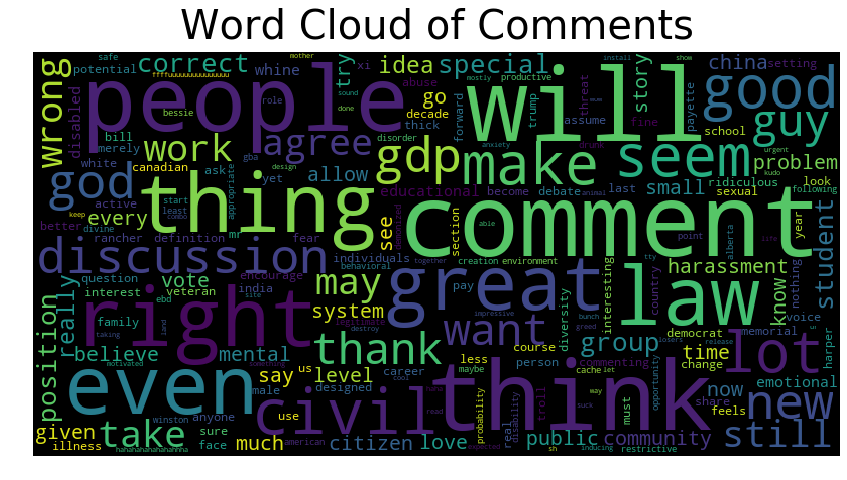

In [29]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,8.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train["comment_text"], title="Word Cloud of Comments")

In [30]:
my_columns = ['target',
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

train_orig = pd.read_csv( path_data + "train.csv")
train = pd.concat([train, train_orig[my_columns]], axis=1)
del(train_orig)
# gc.collect()
train['target'] = np.where(train['target'] >= 0.5, 1, 0)

In [31]:
train_df, validate_df = train_test_split(train, test_size=0.1, random_state = 12)
print(f'{len(train_df)} train comments, {len(validate_df)} validate comments')

1624386 train comments, 180488 validate comments


In [32]:
del train
gc.collect()

2217

In [33]:
MAX_NB_WORDS = 100_000 #574_312 unique tokens in word_index
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 220

corpus = pd.concat([train_df['comment_text'], validate_df ['comment_text'], test['comment_text']])
corpus = corpus.drop_duplicates()

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(corpus)

In [34]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 297950 unique tokens.


In [35]:
train_text = pad_sequences(tokenizer.texts_to_sequences(train_df['comment_text']), maxlen=MAX_SEQUENCE_LENGTH)
train_labels = train_df['target']
validate_text = pad_sequences(tokenizer.texts_to_sequences(validate_df['comment_text']), maxlen=MAX_SEQUENCE_LENGTH)
validate_labels = validate_df['target']
test_text = pad_sequences(tokenizer.texts_to_sequences(test['comment_text']), maxlen=MAX_SEQUENCE_LENGTH)

In [36]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
num_words_in_embedding = 0

for word, i in word_index.items():
    if word in embeddings_index.vocab:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
        num_words_in_embedding += 1

In [37]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [38]:
del (embedding_matrix, embeddings_index, corpus, tokenizer)
gc.collect()

0

### Model architecture

In [39]:
y_aux_train = train_df[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
y_aux_validate = validate_df[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
num_categories_train = y_aux_train.shape[1]

In [40]:
#class_weight = {0: 1., 1: 2.}

In [41]:
def build_model():
    sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH,),  dtype='int32')
    x = embedding_layer(sequence_input)

    x = SpatialDropout1D(0.2)(x)

    x1 = Bidirectional(CuDNNLSTM(128, return_sequences = True))(x)
    x2 = Bidirectional(CuDNNLSTM(32, return_sequences = True))(x1)

    avg_pool = GlobalAveragePooling1D()(x2)
    max_pool = GlobalMaxPooling1D()(x2)

    vf = concatenate([avg_pool, max_pool])
    vf = BatchNormalization()(vf)

    #vf = Dropout(0.2)(Dense(64, activation='relu') (vf))

    preds = Dense(1, activation='sigmoid', name = 'target')(vf)
    preds_aux = Dense(num_categories_train, activation = 'sigmoid', name = 'categories')(vf)

    model = Model(inputs = sequence_input, outputs=[preds, preds_aux])
    model.compile(loss = 'binary_crossentropy',
                      optimizer = 'adam',
                      metrics=['acc'])
    
    
    #model.summary()

   
    #model = load_model(file_path)
    return model

In [42]:
NUM_MODELS = 2
EPOCHS = 4
checkpoint_predictions_val = []
checkpoint_predictions_test = []
weights_val = []
weights_test = []
file_path = "best_model.hdf5"

for model_i in range(NUM_MODELS):
    model = build_model()
    for glob_epoch in range (EPOCHS):
        model.fit(train_text,
           [train_labels, y_aux_train],
           batch_size=512,
           #class_weight = class_weight,
           epochs=1,
           validation_data=(validate_text, [validate_labels, y_aux_validate]),
           callbacks = [EarlyStopping(monitor='val_categories_loss', mode='min', verbose=1, patience=1),             
                        ModelCheckpoint(file_path, monitor = "val_categories_loss", verbose = 1,
                                        save_best_only = True, mode = "min"),
                       LearningRateScheduler(lambda epoch: 1e-3 * (0.6 ** glob_epoch))],
           verbose=0) #Avoid kaggle kernels issues
        checkpoint_predictions_val.append(model.predict(validate_text, batch_size=2048)[0].flatten())
        weights_val.append(2 ** glob_epoch)
        checkpoint_predictions_test.append(model.predict(test_text, batch_size=2048)[0].flatten())
        weights_test.append(2 ** glob_epoch)
        
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Epoch 00001: val_categories_loss improved from inf to 0.08999, saving model to best_model.hdf5

Epoch 00001: val_categories_loss improved from inf to 0.08488, saving model to best_model.hdf5

Epoch 00001: val_categories_loss improved from inf to 0.08571, saving model to best_model.hdf5

Epoch 00001: val_categories_loss improved from inf to 0.08333, saving model to best_model.hdf5

Epoch 00001: val_categories_loss improved from inf to 0.09276, saving model to best_model.hdf5

Epoch 00001: val_categories_loss improved from inf to 0.08516, saving model to best_model.hdf5

Epoch 00001: val_categories_loss improved from inf to 0.08353, saving model to best_model.hdf5

Epoch 00001: v

In [43]:
predictions_val = np.average(checkpoint_predictions_val, weights=weights_val, axis=0)
predictions_test = np.average(checkpoint_predictions_test, weights=weights_test, axis=0)

In [44]:
#Model1 = build_model(epochs=5)

In [45]:
#pred = Model1.predict(validate_text, verbose = 1)[0].flatten()

In [46]:
validate_df['predict_NN'] = predictions_val

In [47]:
print(confusion_matrix(validate_df.target, np.where(validate_df.predict_NN > 0.5, 1, 0)))
print(classification_report(validate_df.target, np.where(validate_df.predict_NN > 0.5, 1, 0)))

[[163684   2327]
 [  6031   8446]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    166011
           1       0.78      0.58      0.67     14477

   micro avg       0.95      0.95      0.95    180488
   macro avg       0.87      0.78      0.82    180488
weighted avg       0.95      0.95      0.95    180488



In [48]:
print('ROC-AUC: {}'.format(roc_auc_score(validate_df.target, validate_df.predict_NN)))

ROC-AUC: 0.9657778737818999


In [49]:
#preds = Model1.predict(test_text, verbose = 1)[0].flatten()

In [50]:
test['prediction'] = predictions_test
test.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,comment_text,prediction
0,7000000,jeff sessions is another one of trump ' s orwellian choices . he believes and has believed his entire career the exact opposite of what the position requires .,0.003180
1,7000001,"i actually inspected the infrastructure on grand chief stewart philip ' s home penticton first nation in both and . exactly zero project that had been identified in previous inspection report had been funded by the federal government , and the entire band was housed in atco trailers . c...",0.000236
2,7000002,"no it will not . that is just wishful thinking on democrat fault . for the th time , walker cited the cost of drug user treatment a being lose with obamacare . i laugh every time i hear a liberal claim republicans want to hurt people , and that is why they dumped obamacare .",0.009754
3,7000003,"instead of wringing our hand and nibble the periphery of the issue , how about we face the actual issue head on ? i would support a city ordinance against loitering , and applaud city councilor who champion a real and permanent solution . the detail can be determined , but would include a l...",0.001188
4,7000004,"how many of you commenters have garbage piled high in your yard , bald tires , dead batteries , rotten pallets , car parts , blah blah blah . this town is a pigpen . drive around and look for yourself , its pathetic .",0.936424


In [51]:
submission = test[['id', 'prediction']]
submission.to_csv('submission.csv', index = False)